In [ ]:
!nvidia-smi

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

import locale
import torch
import os

locale.getpreferredencoding = lambda: "UTF-8"
BASE_PATH = os.path.dirname(os.getcwd())

VISIBLE_GPUS = [0]


os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
print("CUDA GPUS NUMBER: ", torch.cuda.device_count())


### Install Detectron2 and supress warnings

In [ ]:
import os
from IPython import get_ipython
import warnings
warnings.filterwarnings('ignore')


try:
    import detectron2
    print("Detectron2 ALREADY INSTALLED")
    os.chdir(BASE_PATH)
except ModuleNotFoundError:
    !pip install 'git+https://github.com/facebookresearch/detectron2.git'
    if get_ipython():
        get_ipython().kernel.do_shutdown(restart=True)

Detectron2 ALREADY INSTALLED


In [4]:
import torch
print(f'Device Name: {torch.cuda.get_device_name()}')
print(f'Device Available: {torch.cuda.is_available()}')
print(f'Device Count: {torch.cuda.device_count()}')

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

Device Name: NVIDIA H100 80GB HBM3
Device Available: True
Device Count: 1
torch:  2.5 ; cuda:  cu124


### **Mask2Former** Installation

In [ ]:
import os
import subprocess
import sys
import warnings
warnings.filterwarnings('ignore')
MASK2FORMER_PATH = "/Mask2Former"
PIXEL_DECODER_OPS_PATH = os.path.join(MASK2FORMER_PATH, "mask2former/modeling/pixel_decoder/ops")
BASE_PATH = os.path.dirname(os.getcwd())
sys.path.append(MASK2FORMER_PATH)

def install_mask2former():
    if not os.path.exists(MASK2FORMER_PATH):
        print("Cloning Mask2Former...")
        subprocess.run(["git", "clone", "https://github.com/facebookresearch/Mask2Former.git", MASK2FORMER_PATH], check=True)
    else:
        print("Mask2Former repo already exists.")
    
    os.chdir(MASK2FORMER_PATH)
    
    print("Instaling Mask2Former...")
    subprocess.run(["pip", "install", "git+https://github.com/cocodataset/panopticapi.git"], check=True)
    subprocess.run(["pip", "install", "-r", "requirements.txt"], check=True)
    
    os.chdir(PIXEL_DECODER_OPS_PATH)
    
    print("compiling Mask2Former...")
    subprocess.run(["python", "setup.py", "build", "install"], check=True)
    
    os.chdir(BASE_PATH)
    print("Instalation: done!")

def check_mask2former():
    try:
        os.chdir(MASK2FORMER_PATH)
        import mask2former
        print("Mask2Former installed and imported.")
    except (FileNotFoundError, ModuleNotFoundError):
        print("Mask2Former path not found. Instaling...")
        install_mask2former()
        os.kill(os.getpid(), 9)
    finally:
        os.chdir(BASE_PATH)

check_mask2former()

#### Check Lib versions

In [6]:
import torch, detectron2, cv2
import numpy as np
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
NUMPY_VERSION = np.version.version
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
print("opencv:", cv2.__version__)
print("numpy:", np.__version__)

torch:  2.5 ; cuda:  cu124
detectron2: 0.6
opencv: 4.5.5
numpy: 1.26.4


### Fix Mask2Former file 

Due to a division by zero problem, a fix is needed to avoid this issue

Source: https://github.com/facebookresearch/Mask2Former/issues/58

In [7]:
EDIT_INPLACE = False

!cp {BASE_PATH}/matcher.py {BASE_PATH}/Mask2Former/mask2former/modeling/matcher.py
print("Mask2Former matcher config")

Mask2Former matcher config


# Register Dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from detectron2.data import (
    DatasetMapper,
    MetadataCatalog,
    DatasetCatalog,
    build_detection_train_loader,
    build_detection_test_loader,
    transforms as T,
)


TRAIN_DATASET_IMG = "/dataset/train/images"
VAL_DATASET_IMG = "/dataset/val/images"

TRAIN_DATASET_JSON = "/dataset/train_unified.json"
VAL_DATASET_JSON = "/dataset/val_unified.json"

train_dataset_name = 'unified_train'
val_dataset_name = 'unified_val'


DatasetCatalog.clear()
MetadataCatalog.clear()
register_coco_instances(train_dataset_name, {}, TRAIN_DATASET_JSON, TRAIN_DATASET_IMG)
register_coco_instances(val_dataset_name, {}, VAL_DATASET_JSON, VAL_DATASET_IMG)

### Visualize dataset

images shapes: [(1200, 1600, 3), (1200, 1600, 3), (1200, 1600, 3), (1200, 1600, 3), (1200, 1600, 3), (1200, 1600, 3), (1200, 1600, 3), (1200, 1600, 3), (1200, 1600, 3)]


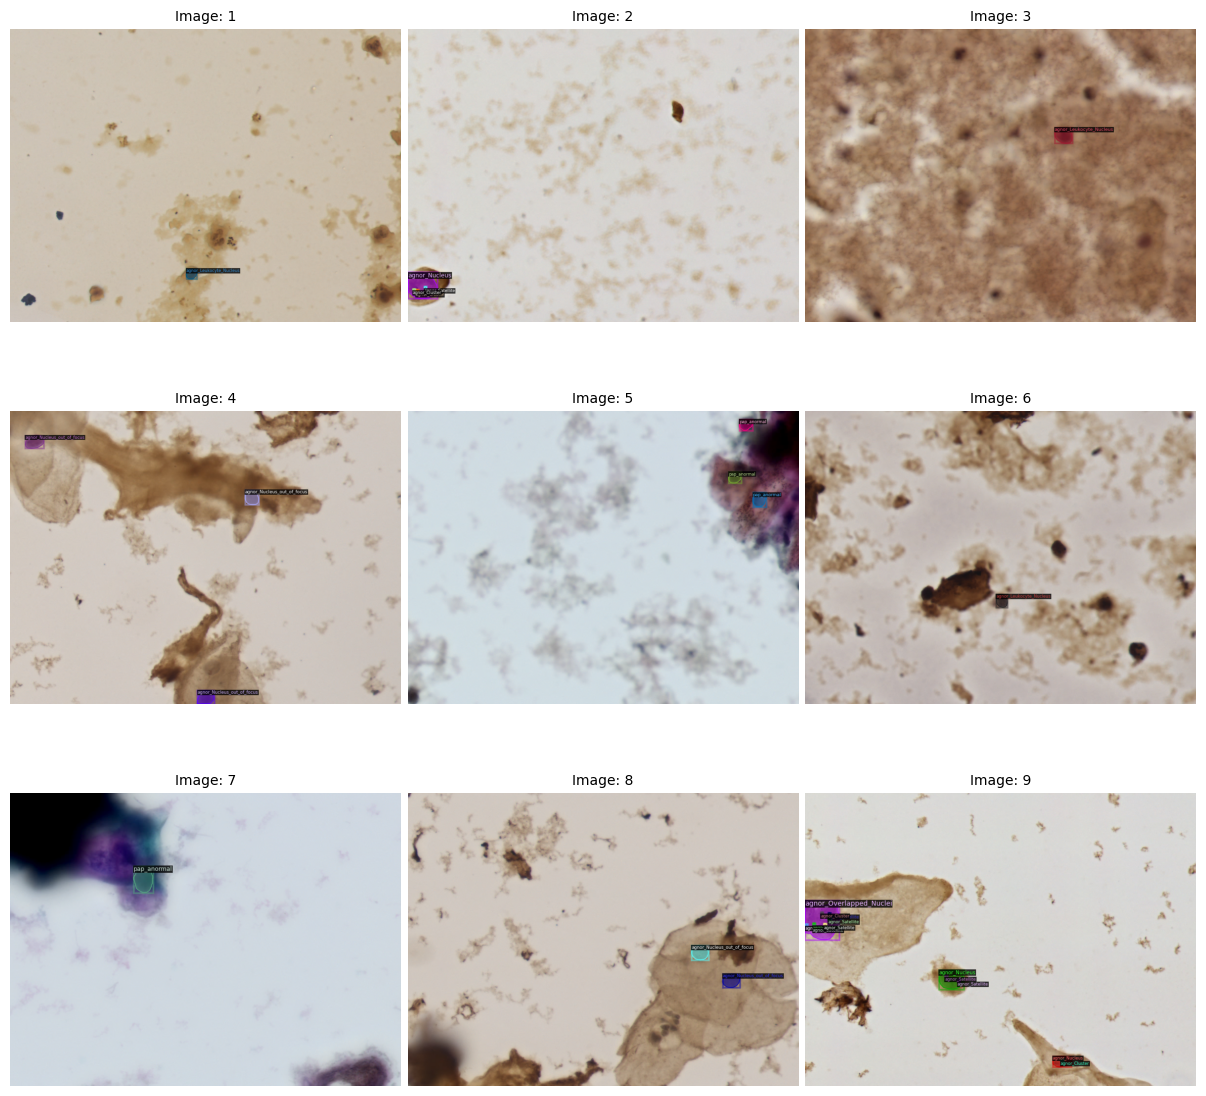

In [10]:
import random
import matplotlib as mpl

def trainer_check(json_test_path, test_images_root_path, n_samples=2, name='test_dataset', rem_background = True):

    if rem_background:
        mpl.rcParams['figure.facecolor'] = 'none'
        mpl.rcParams['axes.facecolor'] = 'none'
    else:
        mpl.rcParams['figure.facecolor'] = 'white'
        mpl.rcParams['axes.facecolor'] = 'white'
        

    register_coco_instances(name, {}, json_test_path, test_images_root_path)
    test_metadata = MetadataCatalog.get(name)
    test_dataset_dicts = DatasetCatalog.get(name)

    ncols = 3
    nrows = int(np.ceil(n_samples / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), constrained_layout=True)

    axs = axs.ravel()

    img_shapes = []

    for i, d in enumerate(random.sample(test_dataset_dicts, n_samples)):
        img = cv2.imread(d["file_name"])
        img_shapes.append(img.shape)
        visualizer = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)

        axs[i].imshow(vis.get_image())#[:, :, ::-1])
        axs[i].axis('off')
        axs[i].set_title(f"Image: {i+1}", fontsize=10)
        # axs[i].set_title(f"Image: {d['file_name'].split('/')[-1]}", fontsize=10)
        axs[i].set_facecolor('none')

    print(f'images shapes: {img_shapes}')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
        axs[j].set_facecolor('none')

    plt.tight_layout(pad=0.5)
    plt.show()

trainer_check(VAL_DATASET_JSON, VAL_DATASET_IMG, n_samples=9, name='dummy_dataset', rem_background=False)

### Import Modules to Train

In [11]:
from detectron2.solver.lr_scheduler import WarmupCosineLR, WarmupMultiStepLR, LRMultiplier, WarmupParamScheduler
from detectron2.data.detection_utils import annotations_to_instances, transform_instance_annotations, read_image
from typing import Callable, Dict, List, Any, Optional, Union
from detectron2.data.datasets import register_coco_instances
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data.build import trivial_batch_collator
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.events import get_event_storage
from detectron2.data.samplers import InferenceSampler
from detectron2.data.common import DatasetFromList
from detectron2.utils.logger import setup_logger
from collections import defaultdict, OrderedDict
from detectron2.config import get_cfg, CfgNode
from detectron2.config import configurable
from typing import Any, Dict, List, Set
import detectron2.utils.comm as comm
import torch.utils.data as torchdata
from detectron2 import model_zoo
from collections import Counter
import matplotlib.pyplot as plt
from torch import autocast
import numpy as np
import itertools
import datetime
import logging
import torch
import json
import copy
import pytz
import cv2
import sys
import os

from detectron2.data import (
    build_detection_train_loader,
    build_detection_test_loader,
    MetadataCatalog,
    DatasetFromList,
    DatasetCatalog,
    DatasetMapper,
    MapDataset,
    transforms as T,
)
from detectron2.engine import (
    default_argument_parser, 
    PeriodicWriter, 
    DefaultTrainer, 
    default_setup, 
    AMPTrainer, 
    HookBase, 
    launch
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    SemSegEvaluator,
    verify_results,
    COCOEvaluator,
    LVISEvaluator,
)
from detectron2.solver.build import (
    get_default_optimizer_params,
    maybe_add_gradient_clipping,
    build_lr_scheduler,
    build_optimizer,
)
from fvcore.common.param_scheduler import (
    StepWithFixedGammaParamScheduler,
    MultiStepParamScheduler,
    CosineParamScheduler,
)
from mask2former import (
    COCOInstanceNewBaselineDatasetMapper,
    COCOPanopticNewBaselineDatasetMapper,
    MaskFormerInstanceDatasetMapper,
    MaskFormerPanopticDatasetMapper,
    MaskFormerSemanticDatasetMapper,
    SemanticSegmentorWithTTA,
    add_maskformer2_config,
    InstanceSegEvaluator,
)

### Trainer and Hooks definitions

In [ ]:
def _validation_loader_from_config(cfg, dataset_name, mapper=None):
    """
    Create a validation data loader from the config.

    Args:
        cfg (CfgNode): configuration options.
        dataset_name (str or list[str]): name of the dataset to load.
        mapper (callable, optional): a callable that takes a dataset dict in
            and returns a format that the model can consume. If None, a default
            mapper will be used.
    """
    if isinstance(dataset_name, str):
        dataset_name = [dataset_name]

    dataset = DatasetCatalog.get(dataset_name[0])
    if isinstance(dataset, list):
        dataset = DatasetFromList(dataset, copy=False)
    if mapper is None:
        mapper = DatasetMapper(cfg, is_train=True)

    dataset = MapDataset(dataset, mapper)

    return {
        "dataset": dataset,
        "mapper": mapper,
        "num_workers": cfg.DATALOADER.NUM_WORKERS,
        "sampler": InferenceSampler(len(dataset)),
        "batch_size": 1,
        "collate_fn": trivial_batch_collator,
    }


@configurable(from_config=_validation_loader_from_config)
def build_detection_validation_loader(
    dataset: Union[List[Any], torchdata.Dataset],
    *,
    mapper: Callable[[Dict[str, Any]], Any],
    sampler: Optional[torchdata.Sampler] = None,
    batch_size: int = 1,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[Any]], Any]] = None,
) -> torchdata.DataLoader:
    """
    Dataloader for Mask2Former.

    Usa:
    - `DatasetMapper(is_train=True)` to keep `instances`, `sem_seg`, etc.
    - `InferenceSampler` will not break training loop.
    - batch size = 1 (default value for valid/test)
    """
    if isinstance(dataset, list):
        dataset = DatasetFromList(dataset, copy=False)
    dataset = MapDataset(dataset, mapper)
    return torchdata.DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        drop_last=False,
        num_workers=num_workers,
        collate_fn=trivial_batch_collator if collate_fn is None else collate_fn,
    )



class ValidationLoss(HookBase):
    def __init__(self, cfg, period=20):
        super().__init__()
        self.cfg = cfg.clone()
        self._period = period

        mapper_name = cfg.INPUT.DATASET_MAPPER_NAME
        if mapper_name == "mask_former_semantic":
            mapper = MaskFormerSemanticDatasetMapper(cfg, is_train=True)
        elif mapper_name == "mask_former_panoptic":
            mapper = MaskFormerPanopticDatasetMapper(cfg, is_train=True)
        elif mapper_name == "mask_former_instance":
            mapper = MaskFormerInstanceDatasetMapper(cfg, is_train=True)
        elif mapper_name == "coco_instance_lsj":
            mapper = COCOInstanceNewBaselineDatasetMapper(cfg, is_train=True)
        elif mapper_name == "coco_panoptic_lsj":
            mapper = COCOPanopticNewBaselineDatasetMapper(cfg, is_train=True)
        else:
            mapper = CustomMapper(DatasetCatalog.get(cfg.DATASETS.TEST[0]))

        self._loader = iter(build_detection_validation_loader(cfg, cfg.DATASETS.TEST[0], mapper=mapper))

    def after_step(self):
        if (self.trainer.iter + 1) % self._period != 0 and self.trainer.iter != self.trainer.max_iter - 1:
            return

        try:
            data = next(self._loader)
        except StopIteration:
            mapper_name = self.cfg.INPUT.DATASET_MAPPER_NAME
            if mapper_name == "mask_former_semantic":
                mapper = MaskFormerSemanticDatasetMapper(self.cfg, is_train=True)
            elif mapper_name == "mask_former_panoptic":
                mapper = MaskFormerPanopticDatasetMapper(self.cfg, is_train=True)
            elif mapper_name == "mask_former_instance":
                mapper = MaskFormerInstanceDatasetMapper(self.cfg, is_train=True)
            elif mapper_name == "coco_instance_lsj":
                mapper = COCOInstanceNewBaselineDatasetMapper(self.cfg, is_train=True)
            elif mapper_name == "coco_panoptic_lsj":
                mapper = COCOPanopticNewBaselineDatasetMapper(self.cfg, is_train=True)
            else:
                mapper = CustomMapper(DatasetCatalog.get(self.cfg.DATASETS.TEST[0]))

            self._loader = iter(build_detection_validation_loader(self.cfg, self.cfg.DATASETS.TEST[0], mapper=mapper))
            data = next(self._loader)

        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            losses = sum(loss_dict.values())
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            loss_dict_reduced = {
                f"validation_{k}": v.item()
                for k, v in comm.reduce_dict(loss_dict).items()
            }
            total_loss = sum(loss_dict_reduced.values())

            if comm.is_main_process():
                self.trainer.storage.put_scalars(
                    validation_total_loss=total_loss, **loss_dict_reduced
                )


class SaveBestLoss(HookBase):
    def __init__(self, period=20):
        super().__init__()
        self._period = period
        self._bestloss = 1000
        self._last = -1

    def after_step(self):
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            self.check_model()

    def after_train(self):
        self.check_model()

    def check_model(self):
        storage = get_event_storage()
        allmetrics = defaultdict(dict)
        for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
            if iter <= self._last:
                continue
            allmetrics[iter][k] = v
        if len(allmetrics):
            all_iters = sorted(allmetrics.keys())
            self._last = max(all_iters)
            if "total_loss" in allmetrics[self._last].keys():
                if allmetrics[self._last]["total_loss"] < self._bestloss:
                    self._bestloss = allmetrics[self._last]["total_loss"]
                    self.trainer.checkpointer.save("model_best_loss")


class ExternalLogger(HookBase):
    def __init__(self, period=20, npt=False, wndb=False, resume=False, maxiter = 0):
        super().__init__()
        self._period = period
        self._npt = npt
        self._wndb = wndb
        self._resume = resume
        self._last = -1
        self._params = {"batch_size": BSIZE, "epochs": NUM_EPOCH, "learning_rate": LEARNING_RATE, "scheduler": LR_METHOD.name, "iterations": maxiter}
        if self._npt:
            if self._resume:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN, with_id=NPT_RUN_ID)
            else:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN)
        if self._wndb:
            os.environ["WANDB_SILENT"] = "True"
            os.environ["WANDB_API_KEY"] = WANDB_API_KEY
            if self._resume:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY, id=WANDB_RUN_ID, resume="must")
            else:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY)
        if not self._resume:
            self._npt_run["parameters"] = self._params
            wandb.config.update(self._params)

    def after_step(self):
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            storage = get_event_storage()
            _iter = storage.iter
            self._last = _iter
            for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
                if self._wndb:
                    if self._resume:
                        if wandb.run.step < _iter:
                            wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                    else:
                        wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                if self._npt:
                    if self._resume:
                        if self._npt_run["last_iter"].fetch() < _iter:
                            self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                    else:
                        self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                        self._npt_run["last_iter"] = _iter

    def after_train(self):
        storage = get_event_storage()
        for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
            if iter <= self._last:
                continue
            if self._wndb:
                wandb.log({f'{k.replace("/", "-")}': v}, step=iter)
            if self._npt:
                self._npt_run[k.replace("/", "-")].log(v, step=iter)
        if self._wndb:
            self._wnd_run.finish()
        if self._npt:
            self._npt_run.stop()

class DeepUFSCTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "evaluations")
            os.makedirs(output_folder, exist_ok=True)
        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        # semantic segmentation
        if evaluator_type in ["sem_seg", "ade20k_panoptic_seg"]:
            evaluator_list.append(
                SemSegEvaluator(
                    dataset_name,
                    distributed=True,
                    output_dir=output_folder,
                )
            )
        # instance segmentation
        if evaluator_type == "coco":
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        # panoptic segmentation
        if evaluator_type in [
            "coco_panoptic_seg",
            "ade20k_panoptic_seg",
            "cityscapes_panoptic_seg",
            "mapillary_vistas_panoptic_seg",
        ]:
            if cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON:
                evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
        # COCO
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Mapillary Vistas
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Cityscapes
        if evaluator_type == "cityscapes_instance":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesInstanceEvaluator(dataset_name)
        if evaluator_type == "cityscapes_sem_seg":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesSemSegEvaluator(dataset_name)
        if evaluator_type == "cityscapes_panoptic_seg":
            if cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesSemSegEvaluator(dataset_name))
            if cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesInstanceEvaluator(dataset_name))
        # ADE20K
        if evaluator_type == "ade20k_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        # LVIS
        if evaluator_type == "lvis":
            return LVISEvaluator(dataset_name, output_dir=output_folder)
        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)

    @classmethod
    def build_train_loader(cls, cfg):
        # Semantic segmentation dataset mapper
        if cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_semantic":
            mapper = MaskFormerSemanticDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # Panoptic segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_panoptic":
            mapper = MaskFormerPanopticDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # Instance segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_instance":
            mapper = MaskFormerInstanceDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco instance segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_instance_lsj":
            mapper = COCOInstanceNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco panoptic segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_panoptic_lsj":
            mapper = COCOPanopticNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # custom data mapper se necessario
        else:
            mapper = CustomMapper(DatasetCatalog.get(cfg.DATASETS.TRAIN[0]))
            return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        name = cfg.SOLVER.LR_SCHEDULER_NAME
        if name == "WarmupMultiStepLR":
            steps = [x for x in cfg.SOLVER.STEPS if x <= cfg.SOLVER.MAX_ITER]
            if len(steps) != len(cfg.SOLVER.STEPS):
                logger = logging.getLogger(__name__)
                logger.warning("SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.")
            sched = MultiStepParamScheduler(
              values=[cfg.SOLVER.GAMMA**k for k in range(len(steps) + 1)],
              milestones=steps,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "WarmupCosineLR":
            end_value = cfg.SOLVER.BASE_LR_END / cfg.SOLVER.BASE_LR
            assert end_value >= 0.0 and end_value <= 1.0, end_value
            sched = CosineParamScheduler(1, end_value)
        elif name == "WarmupStepWithFixedGammaLR":
            sched = StepWithFixedGammaParamScheduler(
              base_value=1.0,
              gamma=cfg.SOLVER.GAMMA,
              num_decays=cfg.SOLVER.NUM_DECAYS,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "OneCycleLR":
            return torch.optim.lr_scheduler.OneCycleLR(
                optimizer, max_lr=cfg.ONECYCLE.LIMIT, 
                base_momentum=cfg.ONECYCLE.MIN_MOMENTUM, 
                max_momentum=cfg.ONECYCLE.MAX_MOMENTUM, 
                total_steps=cfg.SOLVER.MAX_ITER, 
                three_phase=cfg.ONECYCLE.THREE_PHASE)
        else:
            print("Unknown LR scheduler: {}".format(name), "Switching to Default")
            return build_lr_scheduler(cfg, optimizer)

        sched = WarmupParamScheduler(
          sched,
          cfg.SOLVER.WARMUP_FACTOR,
          min(cfg.SOLVER.WARMUP_ITERS / cfg.SOLVER.MAX_ITER, 1.0),
          cfg.SOLVER.WARMUP_METHOD,
          cfg.SOLVER.RESCALE_INTERVAL,
        )
        return LRMultiplier(optimizer, multiplier=sched, max_iter=cfg.SOLVER.MAX_ITER)

    @classmethod
    def build_optimizer(cls, cfg, model):
        weight_decay_norm = cfg.SOLVER.WEIGHT_DECAY_NORM
        weight_decay_embed = cfg.SOLVER.WEIGHT_DECAY_EMBED

        defaults = {}
        defaults["lr"] = cfg.SOLVER.BASE_LR
        defaults["weight_decay"] = cfg.SOLVER.WEIGHT_DECAY

        norm_module_types = (
            torch.nn.BatchNorm1d,
            torch.nn.BatchNorm2d,
            torch.nn.BatchNorm3d,
            torch.nn.SyncBatchNorm,
            # NaiveSyncBatchNorm inherits from BatchNorm2d
            torch.nn.GroupNorm,
            torch.nn.InstanceNorm1d,
            torch.nn.InstanceNorm2d,
            torch.nn.InstanceNorm3d,
            torch.nn.LayerNorm,
            torch.nn.LocalResponseNorm,
        )

        params: List[Dict[str, Any]] = []
        memo: Set[torch.nn.parameter.Parameter] = set()
        for module_name, module in model.named_modules():
            for module_param_name, value in module.named_parameters(recurse=False):
                if not value.requires_grad:
                    continue
                # Avoid duplicating parameters
                if value in memo:
                    continue
                memo.add(value)

                hyperparams = copy.copy(defaults)
                if "backbone" in module_name:
                    hyperparams["lr"] = hyperparams["lr"] * cfg.SOLVER.BACKBONE_MULTIPLIER
                if (
                    "relative_position_bias_table" in module_param_name
                    or "absolute_pos_embed" in module_param_name
                ):
                    print(module_param_name)
                    hyperparams["weight_decay"] = 0.0
                if isinstance(module, norm_module_types):
                    hyperparams["weight_decay"] = weight_decay_norm
                if isinstance(module, torch.nn.Embedding):
                    hyperparams["weight_decay"] = weight_decay_embed
                params.append({"params": [value], **hyperparams})

        def maybe_add_full_model_gradient_clipping(optim):
            # detectron2 doesn't have full model gradient clipping now
            clip_norm_val = cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE
            enable = (
                cfg.SOLVER.CLIP_GRADIENTS.ENABLED
                and cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model"
                and clip_norm_val > 0.0
            )

            class FullModelGradientClippingOptimizer(optim):
                def step(self, closure=None):
                    all_params = itertools.chain(*[x["params"] for x in self.param_groups])
                    torch.nn.utils.clip_grad_norm_(all_params, clip_norm_val)
                    super().step(closure=closure)

            return FullModelGradientClippingOptimizer if enable else optim

        optimizer_type = cfg.SOLVER.OPTIMIZER
        if optimizer_type == "SGD":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.SGD)(
                params, cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM
            )
        elif optimizer_type == "ADAMW":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.AdamW)(
                params, cfg.SOLVER.BASE_LR
            )
        else:
            raise NotImplementedError(f"no optimizer type {optimizer_type}")
        if not cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model":
            optimizer = maybe_add_gradient_clipping(cfg, optimizer)
        return optimizer

    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA.
        logger.info("Running inference with test-time augmentation ...")
        model = SemanticSegmentorWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.VAL
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res


#### Custom Mapper Template

Use this model to create a file mapper using a dictionary, for instance.

In [ ]:
def CustomMapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = read_image(dataset_dict["file_name"], format="BGR")
    auginput = T.AugInput(image)
    transform = T.Resize((800, 800))(auginput)
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [transform_instance_annotations(annotation, [transform], image.shape[1:]) for annotation in dataset_dict.pop("annotations") ]
    return {"image": image, "instances": annotations_to_instances(annos, image.shape[1:])}


### Training Config

In [13]:
from enum import Enum


LR_METHODS = Enum("LR_METHODS", "COSINE FIXED STEP ONECYCLE")

"""
# GENERIC CONFIG
"""
NUM_EPOCH = 10
SAVE_EPOCH = 1
BSIZE = 6
LEARNING_RATE = 0.000005
WARMUP_ITERS = 0

LR_METHOD = LR_METHODS.ONECYCLE

"""
# COSINE CONFIGS (LR_METHODS.COSINE)
"""
LR_MOMENTUM = 0.9


"""
# STEP CONFIGS (LR_METHODS.STEP)
"""
LR_STEPS_DECAY = [0.6, 0.8]
LR_STEP_RATE = 0.1

"""
# ONECYCLE CONFIGS (LR_METHODS.ONECYCLE)
"""
OC_LIMIT = 0.0001
OC_MIN_MOMENTUM = 0.85
OC_MAX_MOMENTUM = 0.95
OC_THREE_PHASE = False


"""
# CONFIG TO SUMMARIZE
"""
RESUMIR = False 
PASTA_RESUMO = os.path.join(BASE_PATH, "RUNS_PATH")

"""
# CONFIG SAVING FOLDER
"""
PROJECT_NAME = "OUTPUTS_UNIFIED"
GDRIVE_SAVE = False 

### Count Categories based on json file

In [14]:
def count_categories(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    if 'categories' in data and isinstance(data['categories'], list):
        return len(data['categories'])
    else:
        return 0


count_categories(TRAIN_DATASET_JSON)

22

For more model specification: <a href=https://github.com/facebookresearch/Mask2Former/blob/main/MODEL_ZOO.md>Mask2Former Model Zoo</a>


<code>cfg.merge_from_file("Mask2Former/configs/coco/instance-segmentation/maskformer2_R50_bs16_50ep.yaml")<br>
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_R50_bs16_50ep/model_final_94dc52.pkl"</code><br>



#### Model configuration name 

In [ ]:
model_config_name = 'maskformer2_swin_base_IN21k_384_bs16_22_classes.yml'

#### Select path to save results

In [ ]:
RUNS_PATH = '/path/to/mask2former/outputs/'
valid = 'valid' if {os.path.isdir(RUNS_PATH)} else 'invalid'
print(f'RUNS_PATH {RUNS_PATH} \n{valid}')

### Set Up Configuration

In [ ]:
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.ONECYCLE = CfgNode({"LIMIT": OC_LIMIT, "MAX_MOMENTUM": OC_MAX_MOMENTUM, "MIN_MOMENTUM": OC_MIN_MOMENTUM, "THREE_PHASE": OC_THREE_PHASE})
cfg.merge_from_file("/Mask2Former/configs/coco/instance-segmentation/swin/maskformer2_swin_base_384_bs16_50ep.yaml")
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_base_IN21k_384_bs16_50ep/model_final_83d103.pkl"
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False
cfg.INPUT.DATASET_MAPPER_NAME = "coco_instance_lsj"
#cfg.INPUT.DATASET_MAPPER_NAME = "custom"
cfg.TEST.EVAL_PERIOD = 0

cfg.DATASETS.TRAIN = (train_dataset_name,)
cfg.DATASETS.TEST = (val_dataset_name,)
##-- END definir caminhos datasets

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.BASE_LR = LEARNING_RATE
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = count_categories(TRAIN_DATASET_JSON)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = count_categories(TRAIN_DATASET_JSON)
cfg.SOLVER.IMS_PER_BATCH = BSIZE # 
cfg.MODEL.RPN.NMS_THRESH = 0.7
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.7]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

NR_IMG = len(DatasetCatalog.get(train_dataset_name))
EPOCH = NR_IMG / cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.MAX_ITER = int(NUM_EPOCH * EPOCH) #
cfg.SOLVER.WARMUP_ITERS = WARMUP_ITERS

cfg.SOLVER.AMP.ENABLED = False
cfg.SOLVER.CLIP_GRADIENTS = CfgNode({
    "ENABLED": True,
    "CLIP_TYPE": "full_model",
    "CLIP_VALUE": 1.0,
    "NORM_TYPE": 2.0
})

if LR_METHOD == LR_METHODS.COSINE:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
    cfg.SOLVER.MOMENTUM = LR_MOMENTUM
elif LR_METHOD == LR_METHODS.STEP:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
    cfg.SOLVER.GAMMA = LR_STEP_RATE
    cfg.SOLVER.STEPS = tuple( [int(cfg.SOLVER.MAX_ITER*LR_STEPS_DECAY[i]) for i in range(len(LR_STEPS_DECAY))])
elif LR_METHOD == LR_METHODS.FIXED:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
    cfg.SOLVER.STEPS = []
elif LR_METHOD == LR_METHODS.ONECYCLE:
    cfg.SOLVER.LR_SCHEDULER_NAME = "OneCycleLR"
    cfg.ONECYCLE.LIMIT = OC_LIMIT
    cfg.ONECYCLE.MIN_MOMENTUM = OC_MIN_MOMENTUM
    cfg.ONECYCLE.MAX_MOMENTUM = OC_MAX_MOMENTUM
    cfg.ONECYCLE.THREE_PHASE = OC_THREE_PHASE
    cfg.SOLVER.WARMUP_ITERS = 0
    cfg.SOLVER.STEPS = []
else:
    pass

EPOCH_RATIO = NUM_EPOCH / SAVE_EPOCH

cfg.SOLVER.CHECKPOINT_PERIOD = int(cfg.SOLVER.MAX_ITER/EPOCH_RATIO)
current_run = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
dirname = "{dia}-{mes}-{ano}_{hora}_{minuto}_{segundo}".format(dia=current_run.day, mes=current_run.month, ano=current_run.year, hora=current_run.hour, minuto=current_run.minute, segundo=current_run.second)
OUTDIR = os.path.join(RUNS_PATH, dirname)
os.makedirs(OUTDIR, exist_ok=True)
cfg.OUTPUT_DIR = OUTDIR

default_setup(cfg, '')

with open(os.path.join(OUTDIR, model_config_name),'w') as f:
    f.write(cfg.dump())

### Train

In [ ]:
time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
_msg = "Starting Training: (Started in {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
print(_msg)

best_hook = SaveBestLoss()
trainer = DeepUFSCTrainer(cfg)
trainer.register_hooks([ValidationLoss(cfg), best_hook])
pw_hook = [hook for hook in trainer._hooks if isinstance(hook, PeriodicWriter)]
all_hooks = [hook for hook in trainer._hooks if not isinstance(hook, PeriodicWriter)]
trainer._hooks = all_hooks + pw_hook

trainer.resume_or_load(resume=False)
trainer.train()

time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
_msg = "Train finished in {dia}/{mes}/{ano} at {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
print(_msg)